# Module 4: Non Linear Models
The goal is developing a machine learning model that, given a user and a product, predicts if the
user would purchase it if they were buying with us at that point in time.

## Load dataset

In [ ]:
import pandas as pd
import logging
from typing import Tuple, List, Dict
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc
import numpy as np
import matplotlib
from sklearn.pipeline import make_pipeline

We will be using our groceries dataset feature_frame_20210304.csv. This is a well
known dataset by now since we have being working on it over the latest several
weeks. For this reason, this project skips the Exploratory Data Analysis (EDA) phase
as it is should already be available in previous reports.

In [15]:
dataset = pd.read_csv('/home/antonio/zrive-ds/src/module_2/groceries_datasets2/raw/feature_frame.csv')

We should only be focusing on purchases of at least 5 items, since it is a
requirement coming from the sales team.

In [16]:
def filter_orders_with_multiple_purchases(dataset: pd.DataFrame, min_items: int = 5) -> pd.DataFrame:
    """
    Filters the dataset to keep only the orders that contain at least `min_items` purchased products.

    Parameters:
    - dataset: The original DataFrame with at least 'order_id' and 'outcome' columns.
    - min_items: Minimum number of purchased products required for an order to be considered valid.

    Returns:
    - A filtered DataFrame containing only the valid orders.
    """
    bought_df = dataset[dataset['outcome'] == 1]
    bought_counts = bought_df['order_id'].value_counts()
    valid_orders = bought_counts[bought_counts >= min_items].index
    filtered_df = dataset[dataset['order_id'].isin(valid_orders)]

    return filtered_df


In [17]:

filtered_df = filter_orders_with_multiple_purchases(dataset, min_items=5)

# Convert to datetime
filtered_df = filtered_df.copy()

filtered_df.loc[:, 'order_date'] = pd.to_datetime(filtered_df['order_date'])
filtered_df.loc[:, 'created_at'] = pd.to_datetime(filtered_df['created_at'])

In [18]:
filtered_df['outcome'].value_counts(normalize=True)

outcome
0.0    0.985522
1.0    0.014478
Name: proportion, dtype: float64

## Dataset Split

As the time interval we have in the dataset is very small (5 months), it is difficult to make a split that meets all the desirable requirements: large set of train to be able to adjust the weights and sufficiently representative sets of validation and test.
In this case I have chosen to make the following split: 70% train, 20% val and 10% test.

Regarding dataleakage, I have ensured that orders that are in one set, are not repeated in another. I have allowed users to be repeated between sets, because I believe that in a real production situation this could be the case.

In [19]:
# Configure logger
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)


def time_aware_order_split_by_percentage(
    df: pd.DataFrame,
    train_frac: float,
    val_frac: float,
    order_date_col: str = 'order_date',
    order_id_col: str = 'order_id',
    user_id_col: str = 'user_id'
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Splits dataset into train/val/test based on time ranges computed from percentages of order_date.

    Args:
        df: Input DataFrame.
        train_frac: Fraction of time to allocate to training.
        val_frac: Fraction of time to allocate to validation.
                  (test_frac is inferred as 1 - train_frac - val_frac)
        order_date_col: Name of the datetime column.
        order_id_col: Name of the order ID column.
        user_id_col: Name of the user ID column.

    Returns:
        Tuple of (train_df, val_df, test_df)
    """

    assert 0 < train_frac < 1, "train_frac must be between 0 and 1"
    assert 0 < val_frac < 1, "val_frac must be between 0 and 1"
    assert (train_frac + val_frac) < 1, "train + val fractions must be < 1"

    min_date = df[order_date_col].min()
    max_date = df[order_date_col].max()
    total_span = (max_date - min_date).days

    train_cutoff = min_date + pd.Timedelta(days=total_span * train_frac)
    val_cutoff = min_date + pd.Timedelta(days=total_span * (train_frac + val_frac))

    train_df = df[df[order_date_col] <= train_cutoff]
    val_df = df[(df[order_date_col] > train_cutoff) & (df[order_date_col] <= val_cutoff)]
    test_df = df[df[order_date_col] > val_cutoff]

    # Assert no leakage 
    assert train_df[order_date_col].max() <= val_df[order_date_col].min(), "Temporal overlap between train and val"
    assert val_df[order_date_col].max() <= test_df[order_date_col].min(), "Temporal overlap between val and test"

    # Logging 
    def log_split_info(name: str, split_df: pd.DataFrame) -> None:
        if len(split_df) == 0:
            logger.warning(f"{name.upper()} SET is empty.")
            return
        logger.info(f"📂 {name.upper()} SET")
        logger.info(f"  ➤ Rows: {len(split_df)}")
        logger.info(f"  ➤ Unique Orders: {split_df[order_id_col].nunique()}")
        logger.info(f"  ➤ Users: {split_df[user_id_col].nunique()}")
        logger.info(f"  ➤ Date range: {split_df[order_date_col].min()} → {split_df[order_date_col].max()}")

    log_split_info("Train", train_df)
    log_split_info("Validation", val_df)
    log_split_info("Test", test_df)

    return train_df, val_df, test_df




In [20]:
train_df, val_df, test_df = time_aware_order_split_by_percentage(
    filtered_df,
    train_frac=0.7,
    val_frac=0.2,
    order_date_col="order_date",
    order_id_col="order_id",
    user_id_col="user_id"
)

INFO:__main__:📂 TRAIN SET
INFO:__main__:  ➤ Rows: 1053466
INFO:__main__:  ➤ Unique Orders: 1369
INFO:__main__:  ➤ Users: 864
INFO:__main__:  ➤ Date range: 2020-10-05 00:00:00 → 2021-01-17 00:00:00
INFO:__main__:📂 VALIDATION SET
INFO:__main__:  ➤ Rows: 658071
INFO:__main__:  ➤ Unique Orders: 752
INFO:__main__:  ➤ Users: 653
INFO:__main__:  ➤ Date range: 2021-01-18 00:00:00 → 2021-02-16 00:00:00
INFO:__main__:📂 TEST SET
INFO:__main__:  ➤ Rows: 452416
INFO:__main__:  ➤ Unique Orders: 482
INFO:__main__:  ➤ Users: 468
INFO:__main__:  ➤ Date range: 2021-02-17 00:00:00 → 2021-03-03 00:00:00


## Evaluation metrics. 

 As there is a clear tradeoff between how many notifications we send and how much we get to increase sales, we will look at the ROC curve and the PR curve.

In [21]:
def evaluate_plot_metrics(
    model_name: str,
    split: str,
    y_pred: pd.Series,
    y_test: pd.Series,
    metrics_store: Dict[str, Dict[str, float]],
    figure: Tuple[matplotlib.figure.Figure, np.array] = None
):
     
    precision_, recall_, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall_, precision_)

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    m = metrics_store.setdefault(model_name, {})
    m[f"{split}_pr_auc"]  = pr_auc
    m[f"{split}_roc_auc"] = roc_auc
    

    if figure is None:
        fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    else:
        fig, ax = figure
    
    ax[0].plot(recall_,precision_, label=f"{model_name} AUC: {pr_auc:.2f}")
    ax[0].set_xlabel("Recall")
    ax[0].set_ylabel("Precision")
    ax[0].set_title(f'Precision-recall curve')
    ax[0].legend()

    ax[1].plot(fpr, tpr, label=f"{model_name} AUC: {roc_auc:.2f}")
    ax[1].set_xlabel("FPR")
    ax[1].set_ylabel("TPR")
    ax[1].set_title(f'ROC Curve')
    ax[1].legend()

## Linear Models Baseline

Classification of variable types

In [22]:
info_cols = ['variant_id', 'order_id', 'user_id', 'created_at', 'order_date']
label_col = 'outcome'
features_cols = [col for col in dataset.columns if col not in info_cols + [label_col]]

categorical_cols = ['product_type', 'vendor']
binary_cols = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']
numerical_cols = [col for col in features_cols if col not in categorical_cols + binary_cols]
datetime_col = ['order_date']

Split into features and label

In [23]:
def prepare_features_and_target(
    df: pd.DataFrame,
    feature_cols: List[str],
    target_col: str
) -> Tuple[pd.DataFrame, pd.Series]:

    # Check errors 
    missing_features = [col for col in feature_cols if col not in df.columns]
    if missing_features:
        raise ValueError(f"Missing feature columns in DataFrame: {missing_features}")
    
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in DataFrame.")

    # Split
    X = df[feature_cols].copy()
    y = df[target_col].copy()

    return X, y

In [24]:
X_train, y_train = prepare_features_and_target(train_df, features_cols, label_col)
X_val, y_val = prepare_features_and_target(val_df, features_cols, label_col)

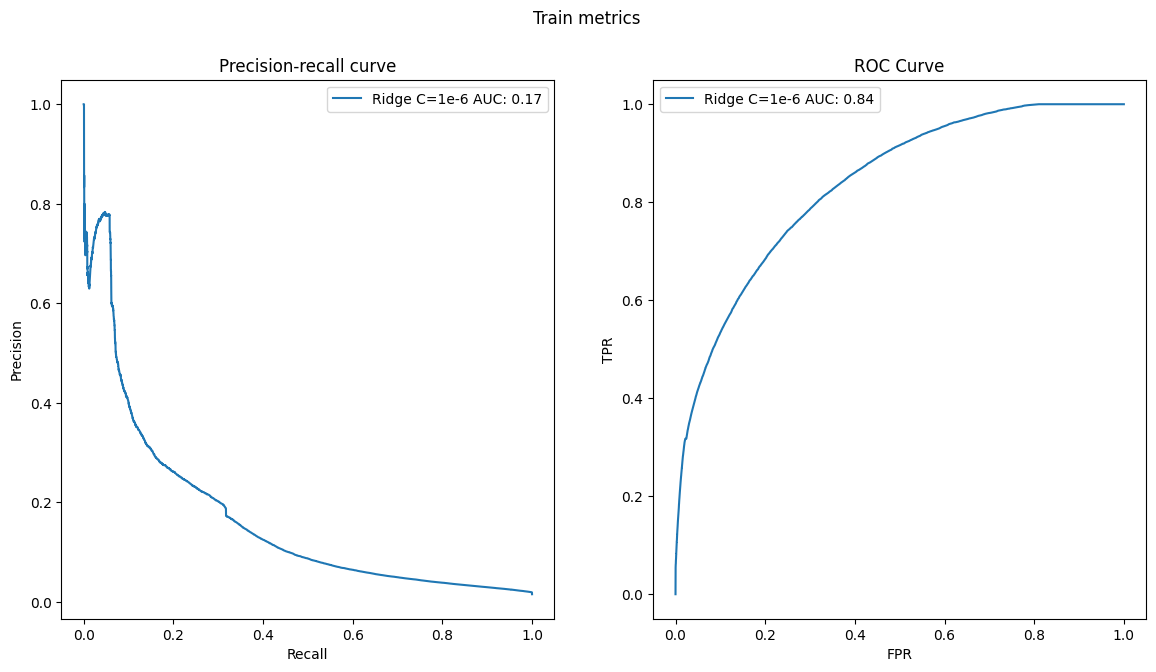

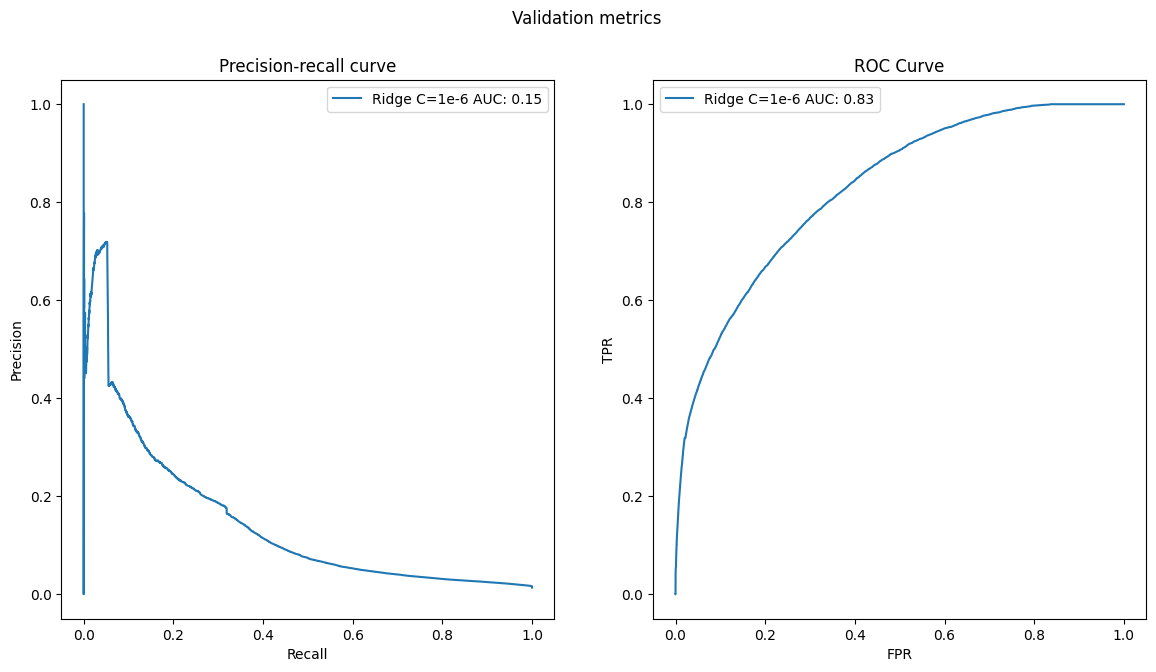

In [25]:
metrics_reduced_cols = {}
reduced_cols = ['ordered_before', 'abandoned_before', 'global_popularity']

fig1, ax1 = plt.subplots(1, 2, figsize=(14, 7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(14, 7))
fig2.suptitle("Validation metrics")

lr = make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty="l2", C=1e-6),
    )

name = 'Ridge C=1e-6'

lr.fit(X_train[reduced_cols], y_train)
train_proba = lr.predict_proba(X_train[reduced_cols])[:, 1]

evaluate_plot_metrics(
    name, split="train", y_pred=train_proba, y_test=train_df[label_col], metrics_store=metrics_reduced_cols, figure=(fig1, ax1)
)

val_proba = lr.predict_proba(X_val[reduced_cols])[:, 1]

evaluate_plot_metrics(
    name, split="val", y_pred=val_proba, y_test=val_df[label_col], metrics_store=metrics_reduced_cols, figure=(fig2, ax2)
)

In [26]:
metrics_df = pd.DataFrame.from_dict(metrics_reduced_cols, orient="index")
print(metrics_df)

              train_pr_auc  train_roc_auc  val_pr_auc  val_roc_auc
Ridge C=1e-6      0.167811       0.835616    0.147323     0.828144


## Non Linear Models

### Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
train_cols = numerical_cols + binary_cols

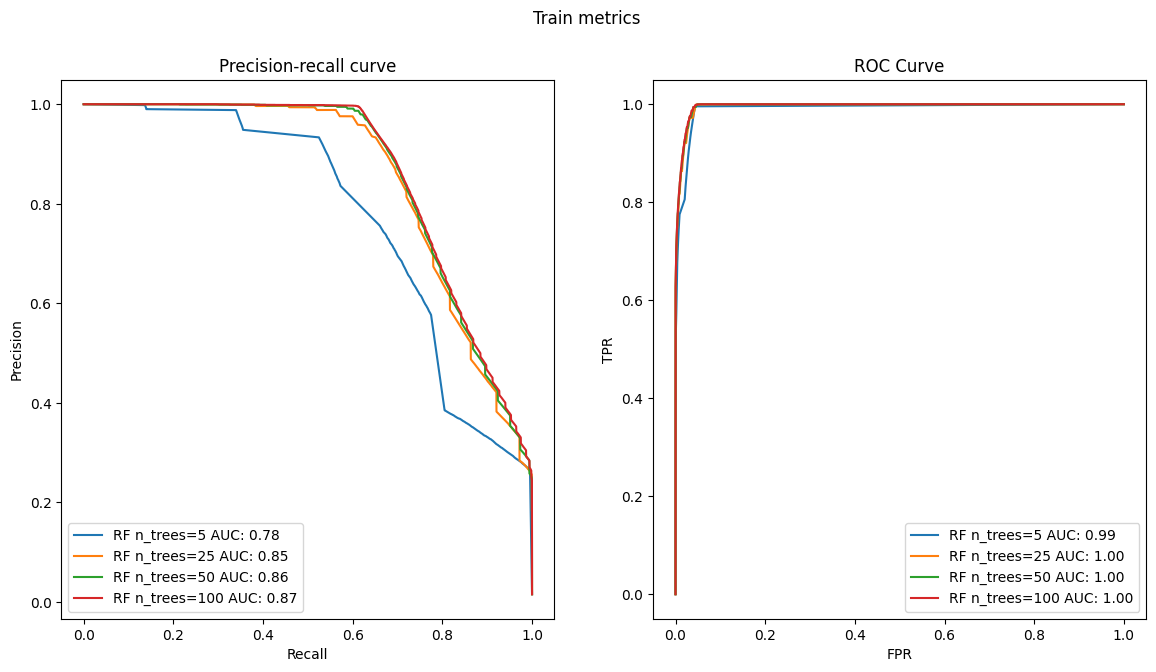

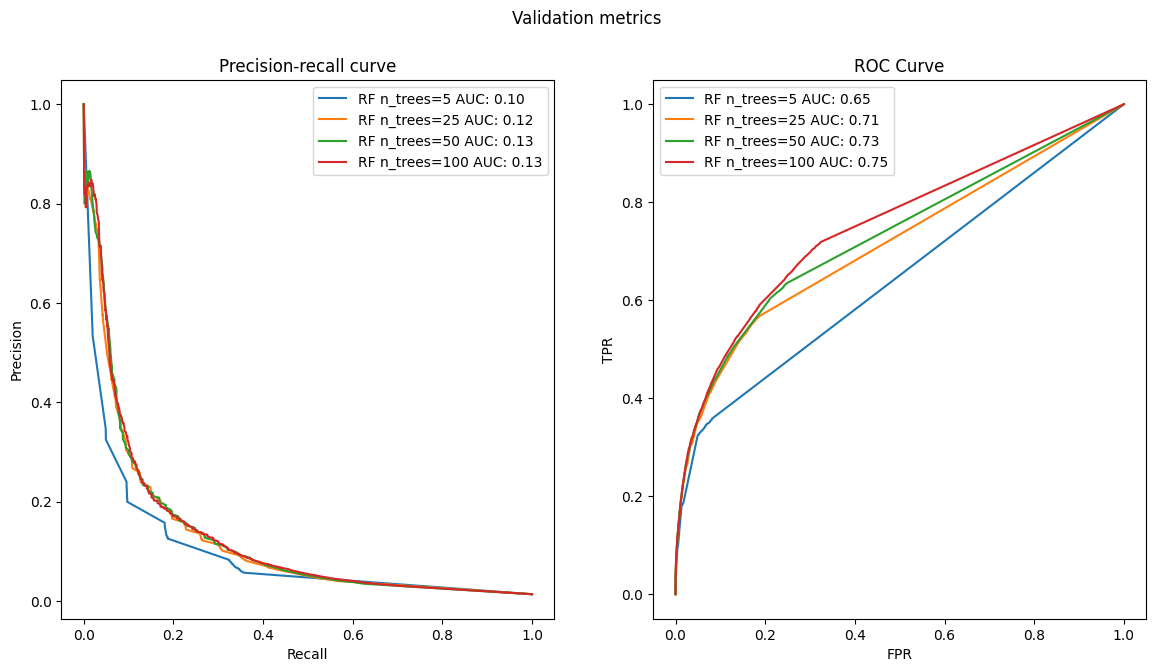

In [29]:
fig1, ax1 = plt.subplots(1, 2, figsize=(14, 7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(14, 7))
fig2.suptitle("Validation metrics")

metrics_rf = {}

n_trees_grid = [5, 25, 50, 100]
for n_trees in n_trees_grid:
    rf = RandomForestClassifier(n_trees)
    rf.fit(X_train[train_cols], y_train)

    name = f'RF n_trees={n_trees}'
    train_proba = rf.predict_proba(X_train[train_cols])[:, 1]
    evaluate_plot_metrics(
        name, split="train", y_pred=train_proba, y_test=train_df[label_col], metrics_store=metrics_rf, figure=(fig1, ax1)
    )

    val_proba = rf.predict_proba(X_val[train_cols])[:, 1]
    evaluate_plot_metrics(
        name, split="val", y_pred=val_proba, y_test=val_df[label_col], metrics_store=metrics_rf, figure=(fig2, ax2)
    )

In [30]:
metrics_rf_df = pd.DataFrame.from_dict(metrics_rf, orient="index")
print(metrics_rf_df)

                train_pr_auc  train_roc_auc  val_pr_auc  val_roc_auc
RF n_trees=5        0.778653       0.990557    0.096536     0.645172
RF n_trees=25       0.854052       0.995293    0.121482     0.714490
RF n_trees=50       0.861814       0.995639    0.125368     0.730064
RF n_trees=100      0.865429       0.995824    0.126550     0.750500


- We observed a significant difference between the training and validation results. As we saw in the theory class, this is not due to overfitting, but rather because the random forest, due to its design, achieves zero error in train (sampling with replacement). The use of independent trees allows it to reduce variance.
- The fact that the error does not reach 0 suggests that there are samples with identical features but different labels.
- The results are poor compared to the linear model

### Feature importance

In [31]:
def plot_feature_importance(clf, columns):
    fig, ax = plt.subplots()
    fi = pd.DataFrame(
        list(zip(columns, clf.feature_importances_)), columns=["features", "importance"]
    ).sort_values(by="importance", ascending=True)
    fi.plot(kind="barh", x="features", y="importance", ax=ax)
    return fi, fig, ax

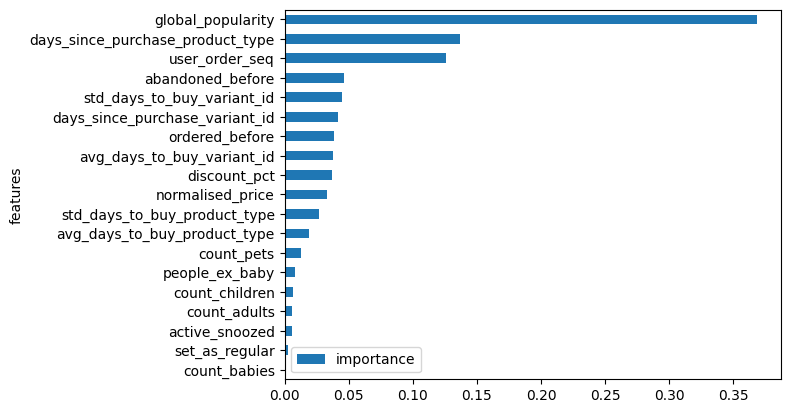

In [32]:
rf_fi, fig, ax = plot_feature_importance(rf, train_cols)

Drop the lest important features

In [33]:
filtered_columns = rf_fi["features"].iloc[:15]

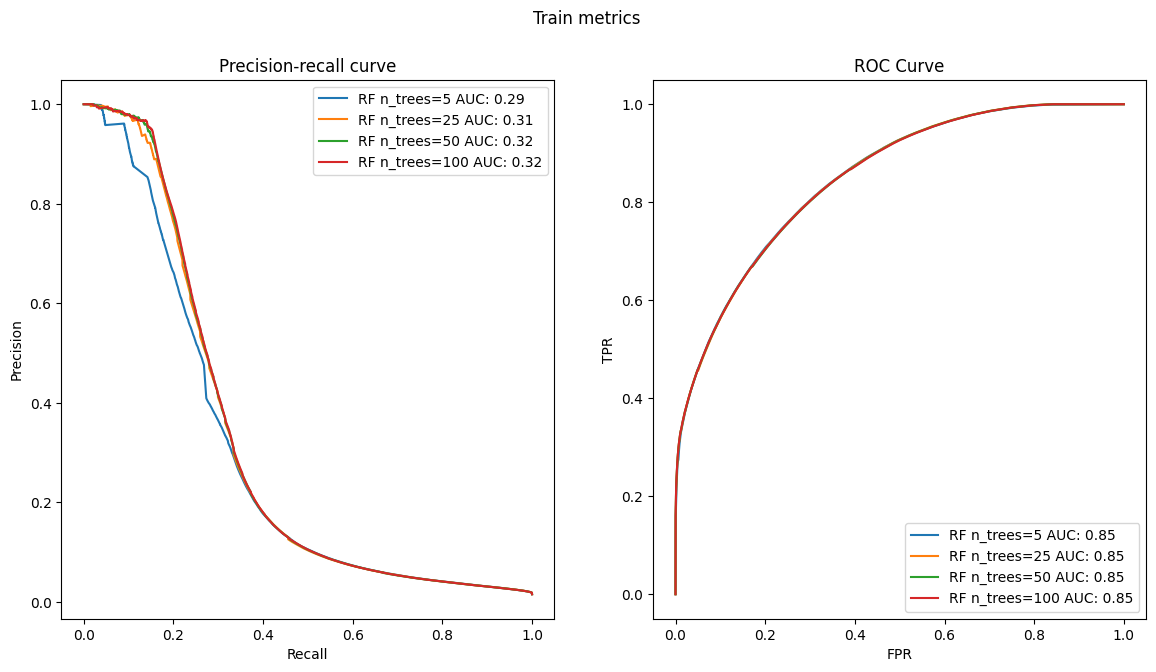

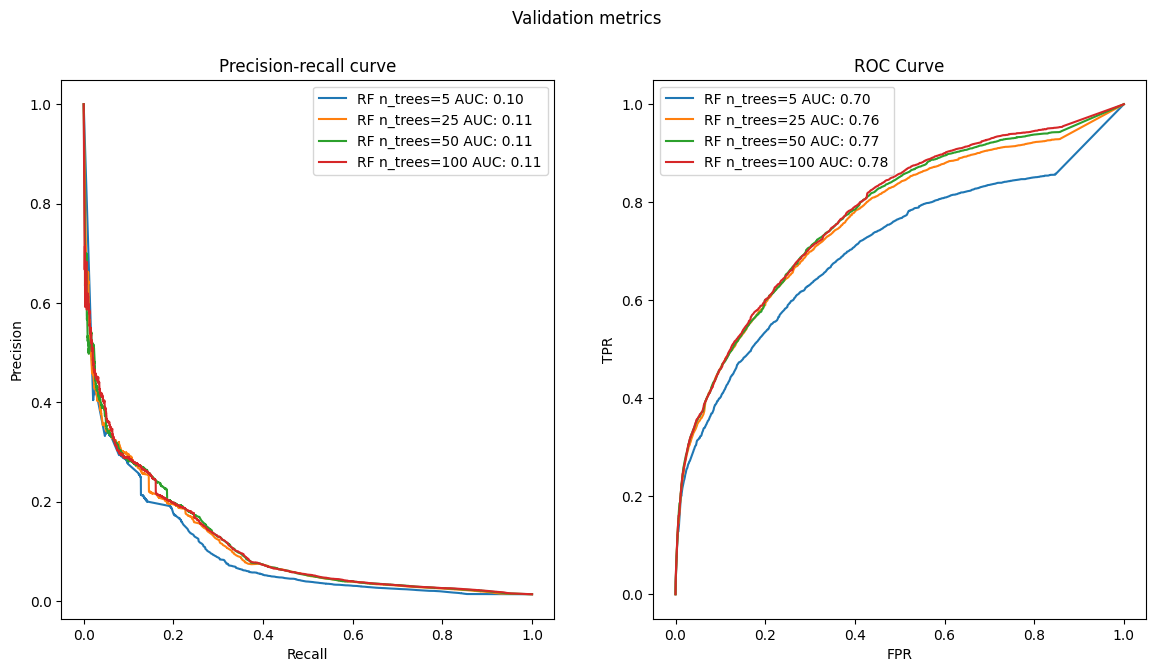

In [34]:
fig1, ax1 = plt.subplots(1, 2, figsize=(14, 7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(14, 7))
fig2.suptitle("Validation metrics")

metrics_rf_reduced_feats = {}

n_trees_grid = [5, 25, 50, 100]
for n_trees in n_trees_grid:
    rf = RandomForestClassifier(n_trees)
    rf.fit(X_train[filtered_columns], y_train)

    name = f'RF n_trees={n_trees}'
    train_proba = rf.predict_proba(X_train[filtered_columns])[:, 1]
    evaluate_plot_metrics(
        name, split="train", y_pred=train_proba, y_test=train_df[label_col], metrics_store=metrics_rf_reduced_feats, figure=(fig1, ax1)
    )

    val_proba = rf.predict_proba(X_val[filtered_columns])[:, 1]
    evaluate_plot_metrics(
        name, split="val", y_pred=val_proba, y_test=val_df[label_col], metrics_store=metrics_rf_reduced_feats, figure=(fig2, ax2)
    )

In [35]:
metrics_rf_reduced_feats_df = pd.DataFrame.from_dict(metrics_rf_reduced_feats, orient="index")
print(metrics_rf_reduced_feats_df)

                train_pr_auc  train_roc_auc  val_pr_auc  val_roc_auc
RF n_trees=5        0.294892       0.849685    0.097995     0.704905
RF n_trees=25       0.313668       0.849666    0.109605     0.763602
RF n_trees=50       0.316394       0.849348    0.112452     0.772982
RF n_trees=100      0.317276       0.849289    0.112751     0.777510


- Retraining with the most important features improves the results. This could be due to correlated variables that led to correlated trees. Another possibility is that having bad features (noise) creates bad trees that contribute to a poor final prediction.
- We see that the accuracy value in train is now lower, due to the same problem as before (identical samples with different labels). Before, we were able to separate them because we had more features.
- The results are still inferior to the linear model.

## Gradient Boosting Trees

In [36]:
from sklearn.ensemble import GradientBoostingClassifier

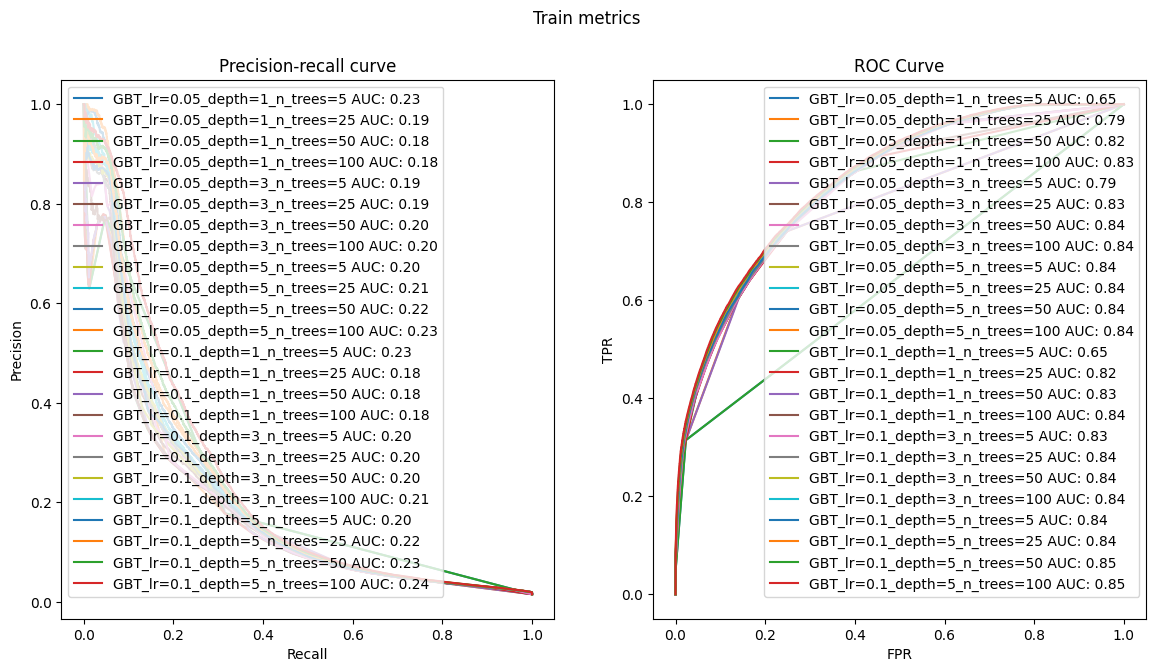

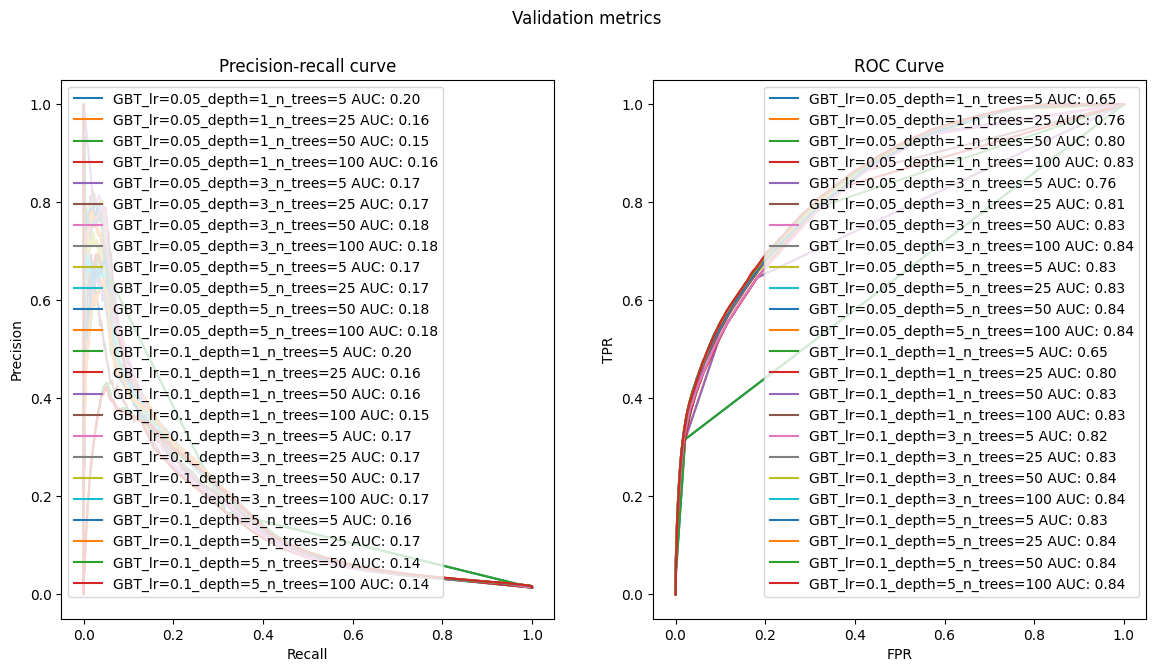

In [37]:
fig1, ax1 = plt.subplots(1, 2, figsize=(14, 7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(14, 7))
fig2.suptitle("Validation metrics")

metrics_gbt = {}

for lrate in [0.05, 0.1]:
    for depth in [1, 3, 5]:
        for n_trees in [5, 25, 50, 100]:
            gbt = GradientBoostingClassifier(learning_rate=lrate, max_depth=depth, n_estimators=n_trees)
            gbt.fit(X_train[train_cols], y_train)

            name = f'GBT_lr={lrate}_depth={depth}_n_trees={n_trees}'
            train_proba = gbt.predict_proba(X_train[train_cols])[:, 1]
            evaluate_plot_metrics(
                name, split="train", y_pred=train_proba, y_test=train_df[label_col], metrics_store=metrics_gbt, figure=(fig1, ax1)
            )

            val_proba = gbt.predict_proba(X_val[train_cols])[:, 1]
            evaluate_plot_metrics(
                name, split="val", y_pred=val_proba, y_test=val_df[label_col], metrics_store=metrics_gbt, figure=(fig2, ax2)
            )

In [38]:
metrics_gbt_df = pd.DataFrame.from_dict(metrics_gbt, orient="index")
print(metrics_gbt_df)

                                 train_pr_auc  train_roc_auc  val_pr_auc  \
GBT_lr=0.05_depth=1_n_trees=5        0.229030       0.646216    0.204385   
GBT_lr=0.05_depth=1_n_trees=25       0.189330       0.786086    0.159681   
GBT_lr=0.05_depth=1_n_trees=50       0.176159       0.815896    0.154730   
GBT_lr=0.05_depth=1_n_trees=100      0.178116       0.832479    0.158928   
GBT_lr=0.05_depth=3_n_trees=5        0.191945       0.786225    0.170530   
GBT_lr=0.05_depth=3_n_trees=25       0.193775       0.825007    0.174708   
GBT_lr=0.05_depth=3_n_trees=50       0.197646       0.837364    0.178892   
GBT_lr=0.05_depth=3_n_trees=100      0.202759       0.840349    0.180896   
GBT_lr=0.05_depth=5_n_trees=5        0.195593       0.837466    0.170019   
GBT_lr=0.05_depth=5_n_trees=25       0.207415       0.839516    0.173202   
GBT_lr=0.05_depth=5_n_trees=50       0.215956       0.841752    0.177173   
GBT_lr=0.05_depth=5_n_trees=100      0.226147       0.844278    0.175834   
GBT_lr=0.1_d

- We chose a hyperparameter configuration based on the metrics and model size.

- In this case, there are several configurations with similar results.

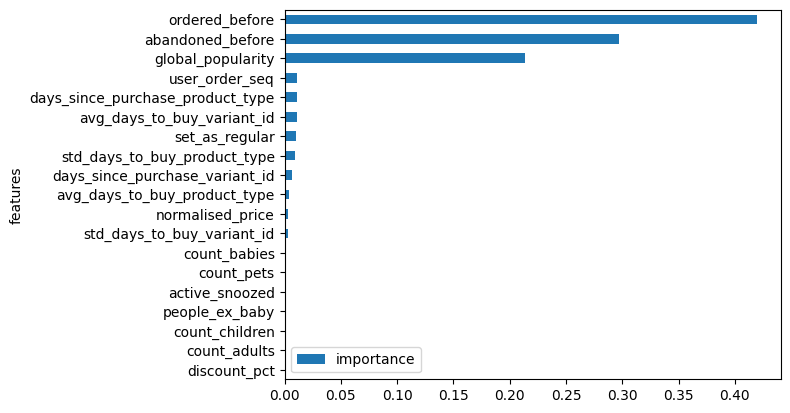

In [39]:
lr_best = 0.05
max_depth_best = 3
n_estimators_best = 50

gbt = GradientBoostingClassifier(
    learning_rate=lr_best, max_depth=max_depth_best, n_estimators=n_estimators_best
)

gbt.fit(X_train[train_cols], y_train)
gbt_fi, fig, ax = plot_feature_importance(gbt, train_cols)

In [41]:
# Select top features from GBT
gbt_columns = (
    gbt_fi.loc[gbt_fi["importance"] > 0]
        .sort_values(by="importance", ascending=False)["features"]
        .tolist()
)
gbt_columns = gbt_columns[:12] 

Analyze how the accuracy of the model varies as we add columns in order of importance.

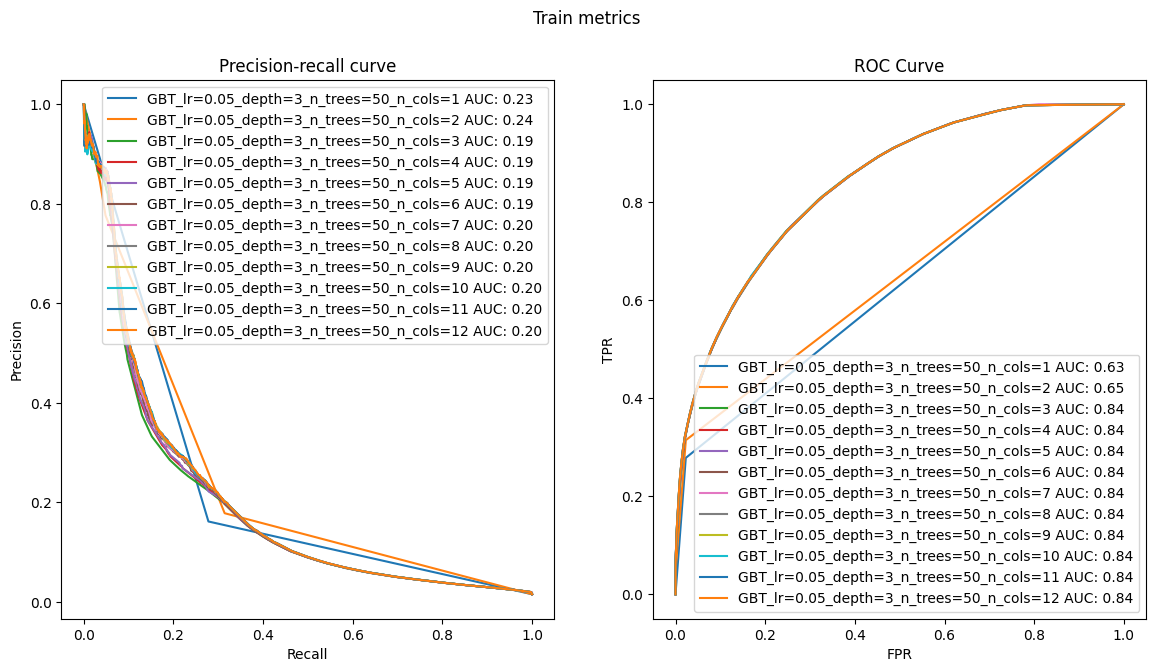

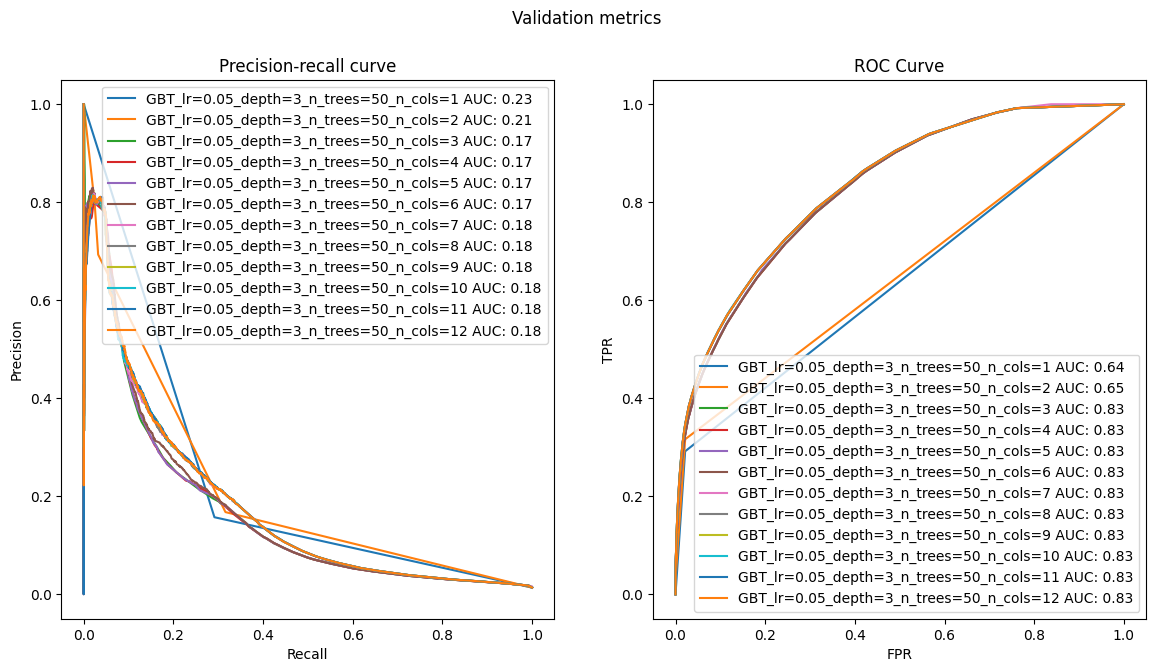

In [45]:
fig1, ax1 = plt.subplots(1, 2, figsize=(14, 7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(14, 7))
fig2.suptitle("Validation metrics")

metrics_gbt = {}


# Loop over increasing number of top features
for i in range(1, len(gbt_columns) + 1):
    gbt = GradientBoostingClassifier(
        learning_rate=lr_best, max_depth=max_depth_best, n_estimators=n_estimators_best
    )

    columns_to_use = gbt_columns[:i]
    gbt.fit(X_train[columns_to_use], y_train)

    name = f'GBT_lr={lr_best}_depth={max_depth_best}_n_trees={n_estimators_best}_n_cols={i}'
    train_proba = gbt.predict_proba(X_train[columns_to_use])[:, 1]
    evaluate_plot_metrics(
        name, split="train", y_pred=train_proba, y_test=train_df[label_col], metrics_store=metrics_gbt, figure=(fig1, ax1)
    )

    val_proba = gbt.predict_proba(X_val[columns_to_use])[:, 1]
    evaluate_plot_metrics(
        name, split="val", y_pred=val_proba, y_test=val_df[label_col], metrics_store=metrics_gbt, figure=(fig2, ax2)
    )

In [46]:
metrics_gbt_df = pd.DataFrame.from_dict(metrics_gbt, orient="index")
print(metrics_gbt_df)

                                          train_pr_auc  train_roc_auc  \
GBT_lr=0.05_depth=3_n_trees=50_n_cols=1       0.225641       0.627644   
GBT_lr=0.05_depth=3_n_trees=50_n_cols=2       0.236899       0.646218   
GBT_lr=0.05_depth=3_n_trees=50_n_cols=3       0.188050       0.837184   
GBT_lr=0.05_depth=3_n_trees=50_n_cols=4       0.190808       0.836889   
GBT_lr=0.05_depth=3_n_trees=50_n_cols=5       0.192483       0.837072   
GBT_lr=0.05_depth=3_n_trees=50_n_cols=6       0.194361       0.836811   
GBT_lr=0.05_depth=3_n_trees=50_n_cols=7       0.195958       0.837543   
GBT_lr=0.05_depth=3_n_trees=50_n_cols=8       0.197206       0.837281   
GBT_lr=0.05_depth=3_n_trees=50_n_cols=9       0.197278       0.837291   
GBT_lr=0.05_depth=3_n_trees=50_n_cols=10      0.197213       0.837485   
GBT_lr=0.05_depth=3_n_trees=50_n_cols=11      0.197661       0.837325   
GBT_lr=0.05_depth=3_n_trees=50_n_cols=12      0.197650       0.837366   

                                          val_pr_a

Final results comparison


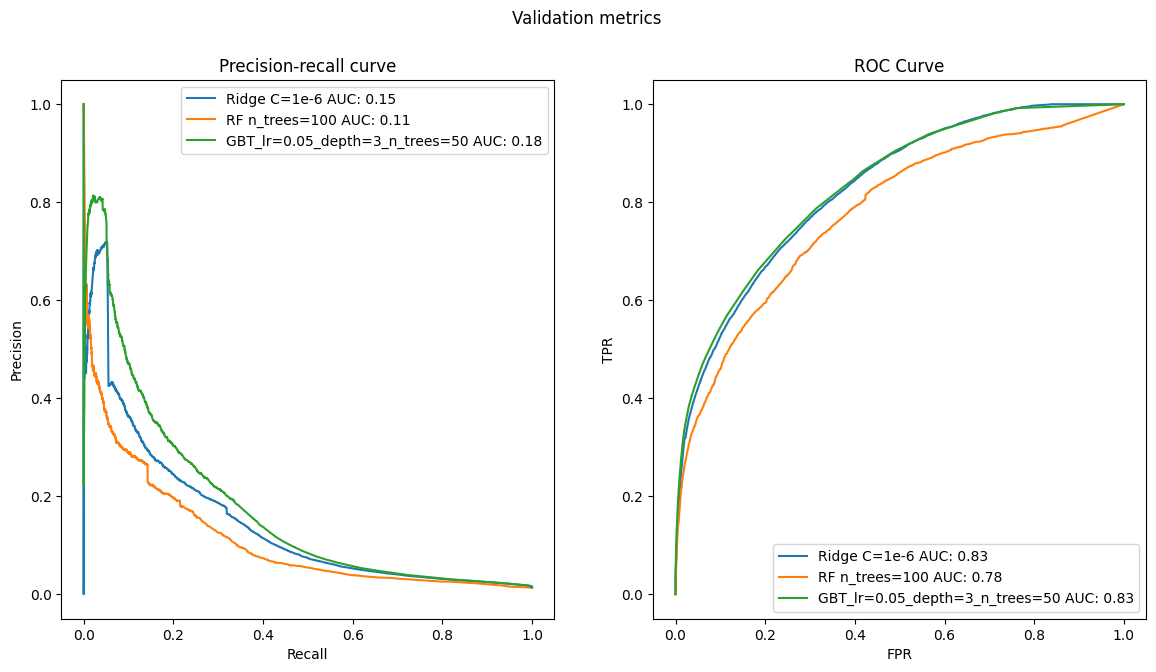

In [51]:
final_metrics = {}
fig2, ax2 = plt.subplots(1, 2, figsize=(14, 7))
fig2.suptitle("Validation metrics")

lr = make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty="l2", C=1e-6),
    )
reduced_cols_lr = ['ordered_before', 'abandoned_before', 'global_popularity']
lr.fit(X_train[reduced_cols_lr], y_train)
lr_predictions = lr.predict_proba(X_val[reduced_cols_lr])[:, 1]
name = 'Ridge C=1e-6'
evaluate_plot_metrics(
    name, split="val", y_pred=lr_predictions, y_test=val_df[label_col], metrics_store=final_metrics, figure=(fig2, ax2)
)

rf = RandomForestClassifier(100)
rf.fit(X_train[filtered_columns], y_train)
name = 'RF n_trees=100'

rf_predictions = rf.predict_proba(X_val[filtered_columns])[:, 1]
evaluate_plot_metrics(
    name, split="val", y_pred=rf_predictions, y_test=val_df[label_col], metrics_store=final_metrics, figure=(fig2, ax2)
)


gbt = GradientBoostingClassifier(
    learning_rate=lr_best, max_depth=max_depth_best, n_estimators=n_estimators_best
)
gbt.fit(X_train[gbt_columns], y_train)

gbt_predictions = gbt.predict_proba(X_val[gbt_columns])[:, 1]
name = f'GBT_lr={lr_best}_depth={max_depth_best}_n_trees={n_estimators_best}'
evaluate_plot_metrics(
    name, split="val", y_pred=gbt_predictions, y_test=val_df[label_col], metrics_store=final_metrics, figure=(fig2, ax2)
)

In [52]:
final_metrics_df = pd.DataFrame.from_dict(final_metrics, orient="index")
print(final_metrics_df)

                                val_pr_auc  val_roc_auc
Ridge C=1e-6                      0.147323     0.828144
RF n_trees=100                    0.111258     0.778746
GBT_lr=0.05_depth=3_n_trees=50    0.178328     0.833055


- Random forest is the one that clearly performs the worst.
- LR and GBT obtain similar ROC AUC values, but GBT is superior in PR AUC

### What point to choose from the AUC and PR curves?

This question should be answered along with business, like how costly is it to miss users (lower recall) vs how costly it is to bother a user with an unwanted push notification (lower precision).

Nevertheless, we can use the information coming from the PRD that “about 5% of push notifications” are opened. Let’s assume that if a user is interested in the product he will open the push. Therefore, we can target those with a probability of interest higher than 5% to start beating the prevalence. Can we do this with our current model?

As we studied in theory, the output scores do not necessarily correspond to probabilities.
Therefore, it is necessary to check the calibration curve.

## Calibration

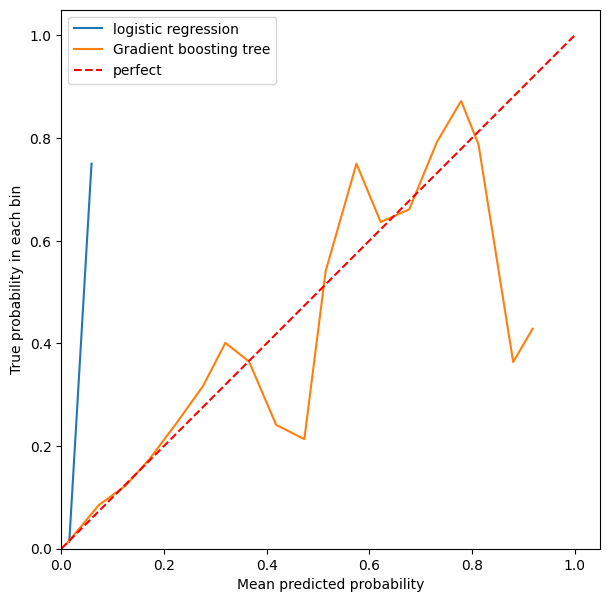

In [53]:
# Calibration
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

lr_prob_true, lr_prob_pred = calibration_curve(y_val, lr_predictions, n_bins=20)
gbt_prob_true, gbt_prob_pred = calibration_curve(y_val, gbt_predictions, n_bins=20)

fig, ax = plt.subplots(figsize=(7, 7))

ax.plot(lr_prob_pred, lr_prob_true, label="logistic regression")
ax.plot(gbt_prob_pred, gbt_prob_true, label="Gradient boosting tree")
ax.plot([0, 1], [0, 1], color="r", linestyle="--", label="perfect")

ax.set_xlabel("Mean predicted probability")
ax.set_ylabel("True probability in each bin")

ax.set_ylim([0, 1.05])
ax.set_xlim([0, 1.05])
ax.set_aspect("equal", "box")
ax.legend()

GBT model has an acceptable calibration although it could be improved while LR is very poorly calibrated.

cv="prefit" because the lr and gbt models have already been trained.
Calibration is performed using the validation data (X_val, y_val) to avoid overfitting the model to the test set (X_test). 
Then, .predict_proba is applied to both the validation and test sets, and separate calibration curves are generated for each dataset and each model

In [54]:
X_test, y_test = prepare_features_and_target(test_df, features_cols, label_col)

calibrated_lr = CalibratedClassifierCV(lr, cv="prefit", method="isotonic")
calibrated_gbt = CalibratedClassifierCV(gbt, cv="prefit", method="isotonic")

# Fit calibration models
calibrated_lr.fit(X_val[reduced_cols_lr], y_val)
val_lr_calibrated_pred = calibrated_lr.predict_proba(X_val[reduced_cols_lr])[:, 1]
test_lr_calibrated_pred = calibrated_lr.predict_proba(X_test[reduced_cols_lr])[:, 1]

calibrated_gbt.fit(X_val[gbt_columns], y_val)
val_gbt_calibrated_pred = calibrated_gbt.predict_proba(X_val[gbt_columns])[:, 1]
test_gbt_calibrated_pred = calibrated_gbt.predict_proba(X_test[gbt_columns])[:, 1]

# Calibration curves
lr_prob_true_val_calibrated, lr_prob_pred_val_calibrated = calibration_curve(
    y_val, val_lr_calibrated_pred, n_bins=20
)
lr_prob_true_test_calibrated, lr_prob_pred_test_calibrated = calibration_curve(
    y_test, test_lr_calibrated_pred, n_bins=20
)

gbt_prob_true_val_calibrated, gbt_prob_pred_val_calibrated = calibration_curve(
    y_val, val_gbt_calibrated_pred, n_bins=20
)
gbt_prob_true_test_calibrated, gbt_prob_pred_test_calibrated = calibration_curve(
    y_test, test_gbt_calibrated_pred, n_bins=20
)

/home/antonio/.cache/pypoetry/virtualenvs/zrive-ds-unSByVQs-py3.11/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/home/antonio/.cache/pypoetry/virtualenvs/zrive-ds-unSByVQs-py3.11/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


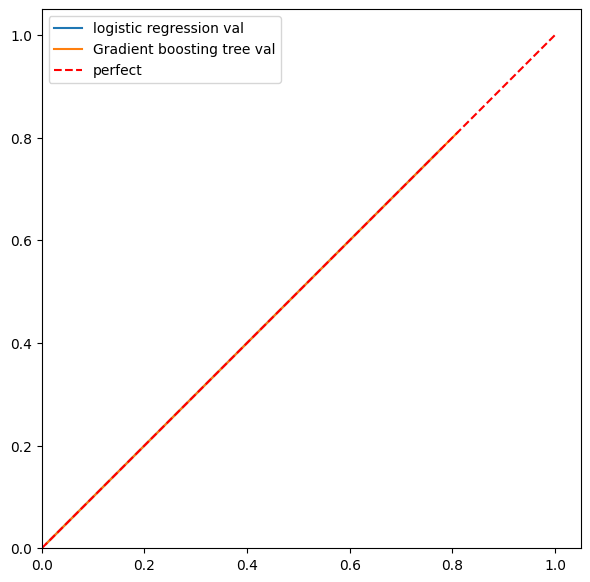

In [59]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.plot(
    lr_prob_pred_val_calibrated,
    lr_prob_true_val_calibrated,
    label="logistic regression val",
    color="C0",
    linestyle="-",
)

ax.plot(
    gbt_prob_pred_val_calibrated,
    gbt_prob_true_val_calibrated,
    label="Gradient boosting tree val",
    color="C1",
    linestyle="-",
)

ax.plot([0, 1], [0, 1], color="r", linestyle="--", label="perfect")


ax.set_ylim([0, 1.05])
ax.set_xlim([0, 1.05])
ax.set_aspect("equal", "box")
ax.legend()

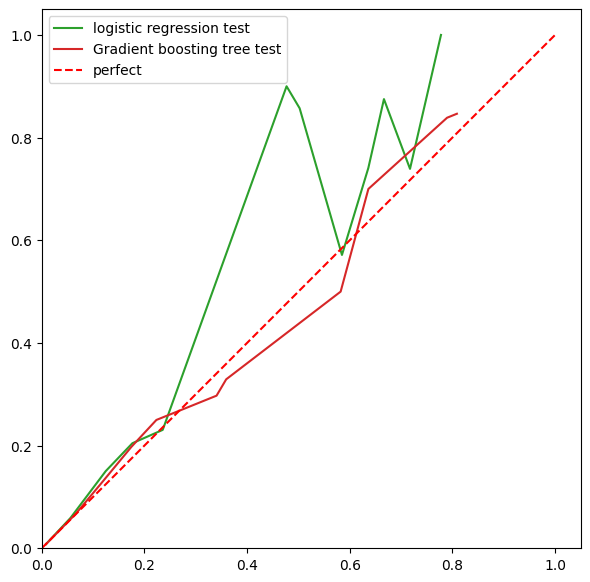

In [57]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.plot(
    lr_prob_pred_test_calibrated,
    lr_prob_true_test_calibrated,
    label="logistic regression test",
    color="C2",
)

ax.plot(
    gbt_prob_pred_test_calibrated,
    gbt_prob_true_test_calibrated,
    label="Gradient boosting tree test",
    color="C3",
)

ax.plot([0, 1], [0, 1], color="r", linestyle="--", label="perfect")

ax.set_ylim([0, 1.05])
ax.set_xlim([0, 1.05])
ax.set_aspect("equal", "box")
ax.legend()

- Once calibrated we can assume that the scores correspond to probabilities
- Any probability value greater than 0.05 is considered "positive"

In [60]:
th = 0.05
gbt_test_binary_pred = (test_gbt_calibrated_pred > th).astype(int)
lr_test_binary_pred = (test_lr_calibrated_pred > th).astype(int)

In [63]:
def get_summary_metrics(y_true, y_pred):
    precision, recall, pr_thresholds = precision_recall_curve(y_true, y_pred)
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_pred)

    roc_auc = roc_auc_score(y_true, y_pred)
    pr_auc = auc(recall, precision)

    return precision, recall, pr_thresholds, fpr, tpr, roc_thresholds, roc_auc, pr_auc

In [64]:
(
    lr_push_precision,
    lr_push_recall,
    lr_push_pr_thresholds,
    lr_push_fpr,
    lr_push_tpr,
    lr_push_roc_thresholds,
    lr_push_roc_auc,
    lr_push_pr_auc,
) = get_summary_metrics(y_test, test_lr_calibrated_pred)

(
    gbt_push_precision,
    gbt_push_recall,
    gbt_push_pr_thresholds,
    gbt_push_fpr,
    gbt_push_tpr,
    gbt_push_roc_thresholds,
    gbt_push_roc_auc,
    gbt_push_pr_auc,
) = get_summary_metrics(y_test, test_gbt_calibrated_pred)

We graph the chosen work point

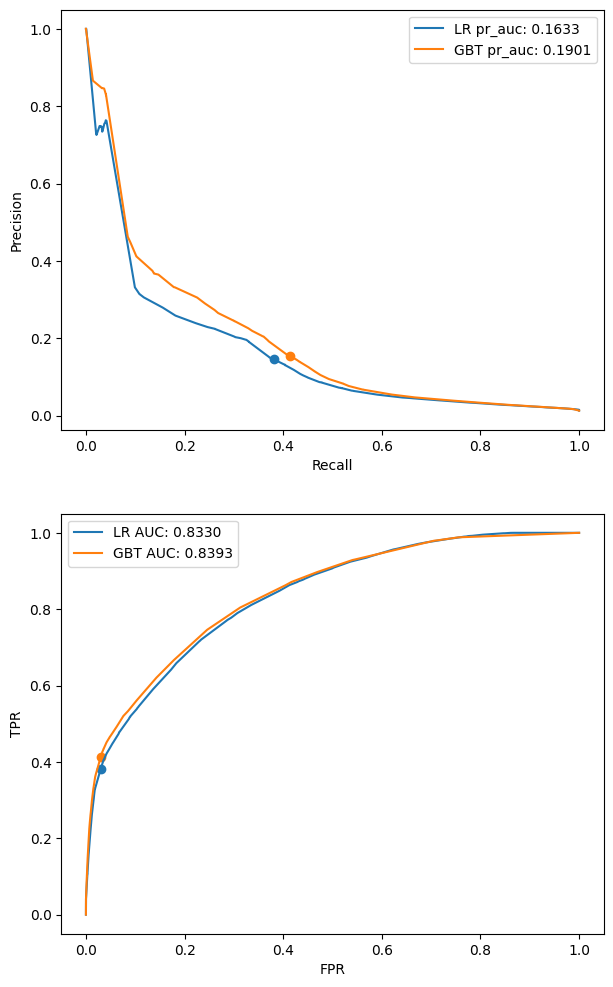

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(7, 12))
# Because PR and ROC curves are generated by evaluating many automatic thresholds, they don't necessarily include your exact custom threshold (0.05).
# Therefore, the closest point is found so that it can be displayed on the curve as a visual reference.
lr_pr_th = np.argmin(np.abs(lr_push_pr_thresholds - th))
gbt_pr_th = np.argmin(np.abs(gbt_push_pr_thresholds - th))

lr_roc_th = np.argmin(np.abs(lr_push_roc_thresholds - th))
gbt_roc_th = np.argmin(np.abs(gbt_push_roc_thresholds - th))

# Precision-Recall Curve
ax[0].plot(lr_push_recall, lr_push_precision, label=f"LR pr_auc: {lr_push_pr_auc:.4f}")
ax[0].scatter(lr_push_recall[lr_pr_th], lr_push_precision[lr_pr_th], label=None, color="C0")

ax[0].plot(gbt_push_recall, gbt_push_precision, label=f"GBT pr_auc: {gbt_push_pr_auc:.4f}")
ax[0].scatter(gbt_push_recall[gbt_pr_th], gbt_push_precision[gbt_pr_th], label=None, color="C1")


ax[0].set_xlabel("Recall")
ax[0].set_ylabel("Precision")
ax[0].legend()

# ROC Curve
ax[1].plot(lr_push_fpr, lr_push_tpr, label=f"LR AUC: {lr_push_roc_auc:.4f}")
ax[1].plot(gbt_push_fpr, gbt_push_tpr, label=f"GBT AUC: {gbt_push_roc_auc:.4f}")
ax[1].scatter(lr_push_fpr[lr_roc_th], lr_push_tpr[lr_roc_th], label=None, color="C0")
ax[1].scatter(gbt_push_fpr[gbt_roc_th], gbt_push_tpr[gbt_roc_th], label=None, color="C1")

ax[1].set_xlabel("FPR")
ax[1].set_ylabel("TPR")
ax[1].legend()